## Install packages

In [ ]:
!pip install scikit-optimize
!pip install catboost
!pip install -U ydata-profiling
!pip install numpy==1.23.5
!pip install sweetviz
!pip install optuna
!pip install shap


## EDA

Missing Values, Basic descriptive statistics

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df_train = pd.read_csv('./train_v9rqX0R.csv')
df_test = pd.read_csv('./test_AbJTz2l.csv')
df_train_profiling = df_train.copy()
df_test_profiling = df_test.copy()

print('Train basic EDA stats \n')
print(df_train.describe(), '\n')
print(df_train.isnull().sum(), '\n\n')


print('Test basic EDA stats \n')
print(df_test.describe(), '\n')
print(df_test.isnull().sum())



Train basic EDA stats 

       Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.643456         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       8.773750         0.026989    93.826500                1987.000000   
50%      12.600000         0.053931   143.012800                1999.000000   
75%      16.850000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800   

Item_Identifier    

In [ ]:
# Use Pandas profiling and Sweetviz for seeing interactions and basic EDA

from ydata_profiling import ProfileReport
import sweetviz as sv

report = sv.analyze(df_train_profiling)
report.show_html()

profile = ProfileReport(df_train_profiling, title="YData Profiling Report")
profile.to_file('train_data.html') #same done for test_data.html
profile.to_notebook_iframe()


### Correlations

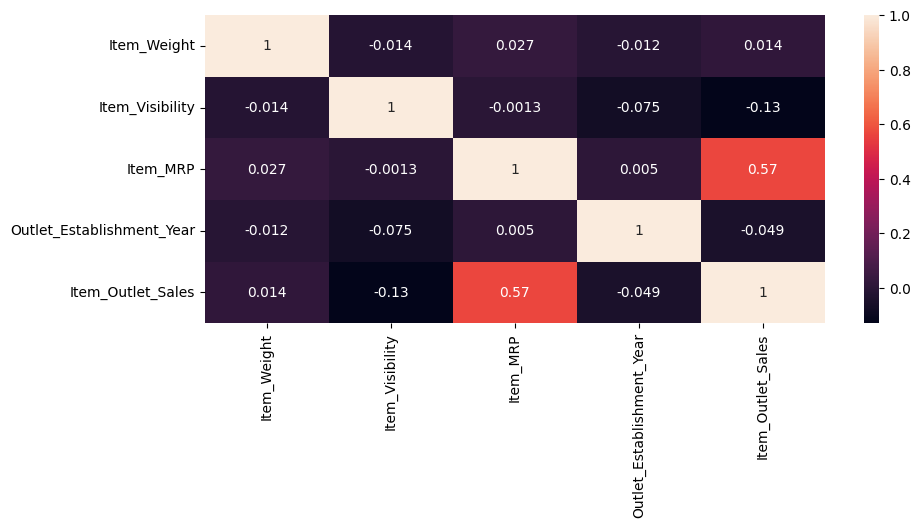

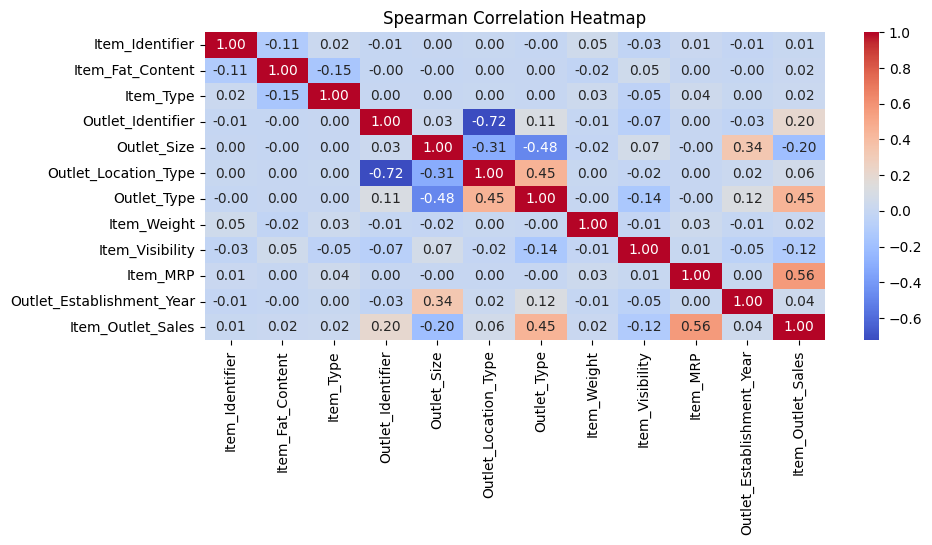

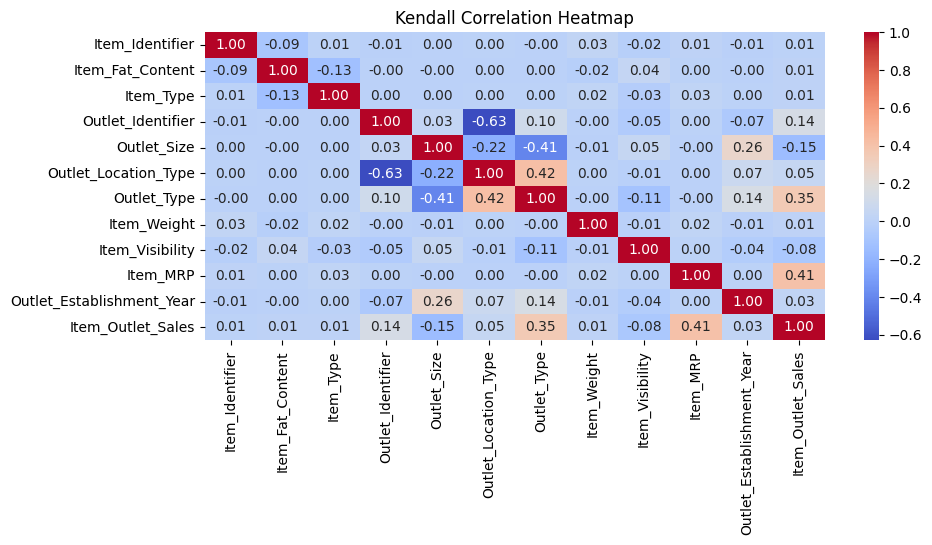

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


df = df_train.copy()

# Item fat has some irregular categories which needs to be fixed
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({
    'LF': 'Low Fat',
    'reg': 'Regular'
})

# Pearson Correlation
plt.figure(figsize=(10,4))
corr = df[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']].corr()
sns.heatmap(corr, annot=True)
plt.show()

# Spearman and Kendalls Correlation

target = 'Item_Outlet_Sales'
features = [col for col in df.columns if col != target]

# Identify categorical and numeric columns
categorical = df.select_dtypes(include='object').columns.tolist()
numeric = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric = [col for col in numeric if col != target]

# Label encode categorical variables
df_encoded = df.copy()
for col in categorical:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

all_features = categorical + numeric

# Spearman correlation matrix
spearman_corr = df_encoded[all_features + [target]].corr(method='spearman')

plt.figure(figsize=(10,4))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Spearman Correlation Heatmap")
plt.show()

# Kendall correlation matrix
kendall_corr = df_encoded[all_features + [target]].corr(method='kendall')

plt.figure(figsize=(10,4))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Kendall Correlation Heatmap")
plt.show()

### Skewness

Skewness of Sales: 1.18


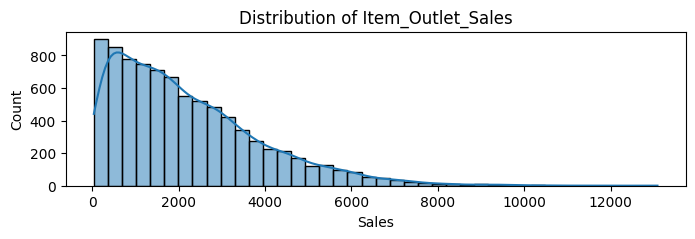

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
skewness = df['Item_Outlet_Sales'].skew()
print(f"Skewness of Sales: {skewness:.2f}")


plt.figure(figsize=(8, 2))
sns.histplot(df['Item_Outlet_Sales'], kde=True, bins=40)
plt.title("Distribution of Item_Outlet_Sales")
plt.xlabel("Sales")
plt.ylabel("Count")
plt.show()

## Skewness is high and tail is towards the right so its right skewed. This shows some high sales but less in number.

Skewness is high and tail is towards the right so its right skewed. This shows some high sales but less in number.

### Tests for Normality

In [ ]:
from scipy.stats import kstest
from scipy.stats import anderson

stat, p = kstest((df['Item_Outlet_Sales'] - df['Item_Outlet_Sales'].mean()) / df['Item_Outlet_Sales'].std(), 'norm')
print('K-S Test: stat=%.3f, p=%.8f' % (stat, p))

standardized_data = ( df['Item_Outlet_Sales'] - np.mean( df['Item_Outlet_Sales'])) / np.std( df['Item_Outlet_Sales'])

result = anderson(standardized_data, dist='norm')
print('Anderson-Darling Statistic:', result.statistic)
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        normalyn = 'likely normal'
    else:
        normalyn = 'not normal'
    print(f'Significance Level {sl:.1f}%: Critical Value = {cv:.3f} => {normalyn}')

K-S Test: stat=0.104, p=0.00000000
Anderson-Darling Statistic: 186.02198188367038
Significance Level 15.0%: Critical Value = 0.576 => not normal
Significance Level 10.0%: Critical Value = 0.656 => not normal
Significance Level 5.0%: Critical Value = 0.787 => not normal
Significance Level 2.5%: Critical Value = 0.918 => not normal
Significance Level 1.0%: Critical Value = 1.091 => not normal


We see ks statistic p is < 0.05 so we reject null hypothesis that this distribution follows a Normal distribution. Anderson Darling test also shows the same at 5% significance and others.

### Check for linearity

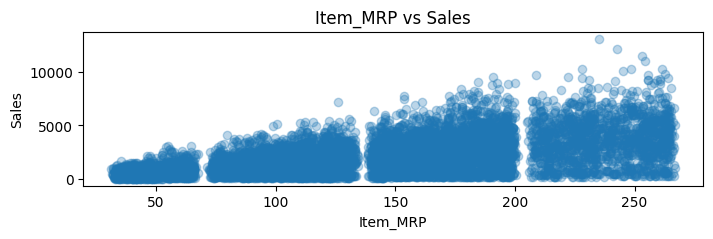

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 2))
plt.scatter(df['Item_MRP'], df['Item_Outlet_Sales'], alpha=0.3)
plt.xlabel('Item_MRP')
plt.ylabel('Sales')
plt.title('Item_MRP vs Sales')
plt.show()

In [ ]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


X = df.drop(columns=['Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=7
)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()


numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

model = Pipeline([
    ('preprocess', preprocessor),
    ('linear', LinearRegression())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_train)
residuals = y_train - y_pred


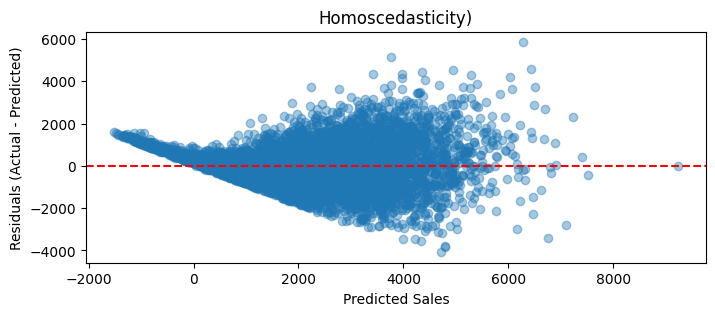

In [ ]:
plt.figure(figsize=(8, 3))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Homoscedasticity)')
plt.show()

This shows residuals not linear as its not homoscedastic. It heteroscedastic as the spread of residuals is increasing.Hence, the data is not linear




#### Data is highly skewed to the right

#### Data is not Normal as seen from KS Test and Anderson Darling test

#### Data is not linear as seen from homoscedasticity test via residual plot.




## FEATURE IMPORTANCE, FEATURE ENGINEERING, FEATURE SELECTION

Now we will do Feature importance, engineering and selection

#### Feature Importance

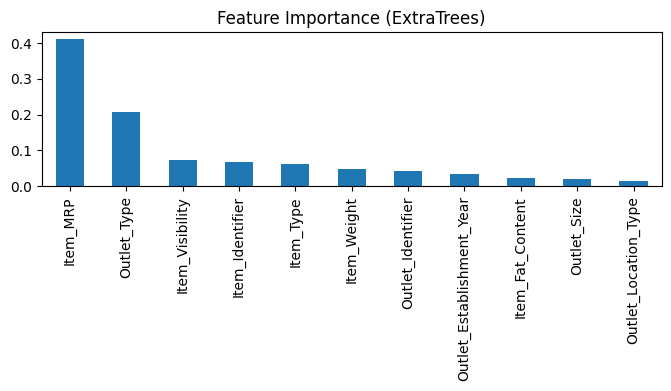

Item_MRP                     0.409398
Outlet_Type                  0.206342
Item_Visibility              0.072414
Item_Identifier              0.067892
Item_Type                    0.061300
Item_Weight                  0.048732
Outlet_Identifier            0.043092
Outlet_Establishment_Year    0.033315
Item_Fat_Content             0.023612
Outlet_Size                  0.019786
Outlet_Location_Type         0.014117
dtype: float64


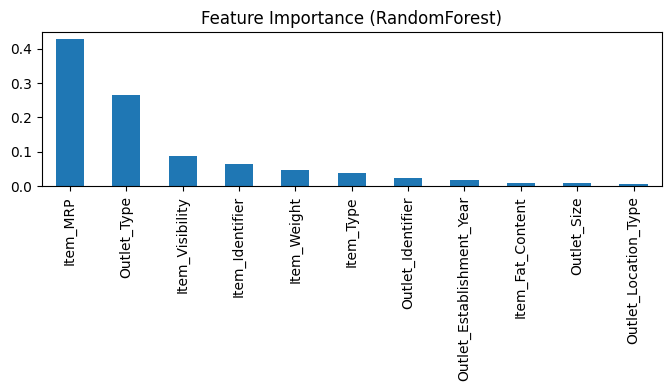

Item_MRP                     0.427089
Outlet_Type                  0.265982
Item_Visibility              0.088536
Item_Identifier              0.065576
Item_Weight                  0.047982
Item_Type                    0.039081
Outlet_Identifier            0.022928
Outlet_Establishment_Year    0.018002
Item_Fat_Content             0.008991
Outlet_Size                  0.008875
Outlet_Location_Type         0.006959
dtype: float64


In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

df_for_model = df.copy()

cat_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size',
            'Outlet_Location_Type', 'Outlet_Type','Item_Identifier']

for col in cat_cols:
    df_for_model[col] = pd.factorize(df_for_model[col])[0]

X = df_for_model.drop(['Item_Outlet_Sales'], axis=1)
y = df_for_model['Item_Outlet_Sales']

model = ExtraTreesRegressor(n_estimators=500, random_state=42)
model.fit(X, y)
importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(8, 2))
importances.sort_values(ascending=False).plot.bar()
plt.title("Feature Importance (ExtraTrees)")
plt.show()
print(importances.sort_values(ascending=False))



df_for_model = df.copy()

cat_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size','Item_Identifier',
            'Outlet_Location_Type', 'Outlet_Type']

for col in cat_cols:
    df_for_model[col] = pd.factorize(df_for_model[col])[0]

X = df_for_model.drop(['Item_Outlet_Sales'], axis=1)
y = df_for_model['Item_Outlet_Sales']

model = RandomForestRegressor(n_estimators=500, random_state=42)
model.fit(X, y)
importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(8, 2))
importances.sort_values(ascending=False).plot.bar()
plt.title("Feature Importance (RandomForest)")
plt.show()
print(importances.sort_values(ascending=False))

We pick the below features before going ahead with Feature creation, Missing Value and Outlier treatment. We will remove features later recursively or at random and check performance.

Item_MRP                   

Outlet_Type                  

Item_Visibility

Item_Identifier

Item_Weight                 

Item_Type                   

Outlet_Identifier            


#### MISSING VALUES
We see below Item Weight and Outlet size have missing values but Outlet Size is not that important as a feature compared to Item weight. So we will only impute missing values of Item Weight.

In [ ]:
df.isnull().sum()

,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


Instead of directly making it median of dataset we should ideally impute it with medians by aggregating it at the Item/Outlet level. For this we need to know which features are important for Item weight. Also **important thing is we notice that many products are repeated and its weight will not change** i.e. Item identifier has unique weight. So we can try to **replace the missing values by mapping known item weights**. With the remaining we can create group aggregate level median and means.

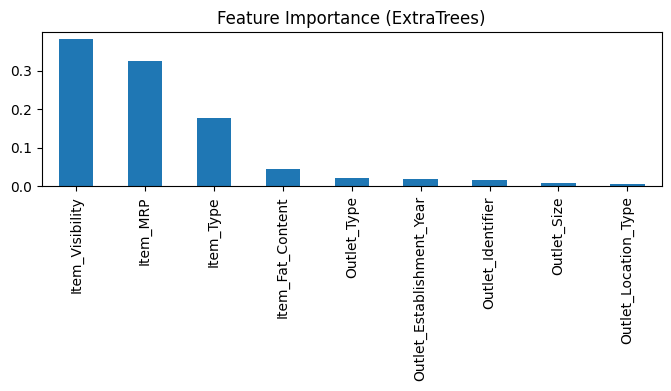

Item_Visibility              0.380688
Item_MRP                     0.325414
Item_Type                    0.177539
Item_Fat_Content             0.043375
Outlet_Type                  0.022034
Outlet_Establishment_Year    0.019355
Outlet_Identifier            0.016340
Outlet_Size                  0.009188
Outlet_Location_Type         0.006068
dtype: float64


In [ ]:
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor

df_for_model = df.copy()
df_for_model = df_for_model.dropna(subset=['Item_Weight'])
cat_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size',
            'Outlet_Location_Type', 'Outlet_Type']

for col in cat_cols:
    df_for_model[col] = pd.factorize(df_for_model[col])[0]

X = df_for_model.drop(['Item_Outlet_Sales', 'Item_Identifier','Item_Weight'], axis=1)
y = df_for_model['Item_Weight']


model = RandomForestRegressor(n_estimators=500, random_state=42)
model.fit(X, y)
importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(8, 2))
importances.sort_values(ascending=False).plot.bar()
plt.title("Feature Importance (ExtraTrees)")
plt.show()
print(importances.sort_values(ascending=False))

We see here Item Visibility and Item MRP are the 2 main features for predicting Item Weight. We will use these two for imputing missing values

We will concatenate both training and test sets first to do feature engineering and imputations.

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np


df_train = pd.read_csv('./train_v9rqX0R.csv')
df_test = pd.read_csv('./test_AbJTz2l.csv')
df_train_profiling = df_train.copy()
df_test_profiling = df_test.copy()


df_train['is_train'] = True
df_test['is_train'] = False
df_test['Item_Outlet_Sales'] = np.nan

df_all = pd.concat([df_train, df_test], ignore_index=True)
print(df_all.isnull().sum().to_frame('num_nulls').reset_index().rename(columns={'index': 'column'}))


                       column  num_nulls
0             Item_Identifier          0
1                 Item_Weight       2439
2            Item_Fat_Content          0
3             Item_Visibility          0
4                   Item_Type          0
5                    Item_MRP          0
6           Outlet_Identifier          0
7   Outlet_Establishment_Year          0
8                 Outlet_Size       4016
9        Outlet_Location_Type          0
10                Outlet_Type          0
11          Item_Outlet_Sales       5681
12                   is_train          0


In [3]:
# Standardize Item_Fat_Content
df_all['Item_Fat_Content'] = df_all['Item_Fat_Content'].replace({
    'LF': 'Low Fat',
    'reg': 'Regular'
})

In [4]:
# Fill Item_Weight based on Item_Identifier (same as before, but on concat)
item_weight_map = df_all.dropna(subset=['Item_Weight']).drop_duplicates('Item_Identifier')[['Item_Identifier', 'Item_Weight']]
item_weight_dict = dict(zip(item_weight_map['Item_Identifier'], item_weight_map['Item_Weight']))

def fill_weight_from_identifier(row):
    if pd.isnull(row['Item_Weight']):
        return item_weight_dict.get(row['Item_Identifier'], np.nan)
    return row['Item_Weight']


df_all['Item_Weight'] = df_all.apply(fill_weight_from_identifier, axis=1)


In [5]:
df_all.isnull().sum()

,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,4016
Outlet_Location_Type,0


We see all missing values of item weights have been filled by their previous weights based on Item Identifier.

##### Feature Engineering and Selection

We create some features namely Item Visibility Bins, Item MRP bins which would have used if the missing values for item weight was still present. This would happen if any new product comes. The method for that imputation is shown below.
Along with that all the features created are:

Item_Visibility_Bin

What: Categorizes Item_Visibility into 5 bins: Very Low to Very High.
Why: Helps group items by visibility range to capture non-linear effects or visibility-driven purchasing patterns.

Item_MRP_Bin

What: Bins Item_MRP (price) into 4 ranges from Low to Very High.
Why: Captures how products perform across different price levels, allowing the model to learn better on price segments.

Item_Weight_Bin

What: Bins Item_Weight into 4 categories from Low to Very High.
Why: Allows model to understand weight as a category, which can interact better with other features.


Outlet_Age

What: Age of outlet = current year (2013) minus establishment year.
Why: Captures maturity of the store, which might affect customer base and sales.

Outlet_Est_Decade

What: Groups outlets by the decade they were established.
Why: Adds temporal structure; older stores may follow different sales patterns than newer ones.

Outlet_Age_Sales_Mean

What: Mean sales for each outlet age.
Why: Provides a prior expectation of sales based on how old the outlet is.

Outlet_Decade_Sales_Mean

What: Mean sales grouped by outlet's founding decade.
Why: Adds sales context by time period, capturing generational patterns.

ItemType_OutletAge_MeanSales

What: Mean sales grouped by item type and outlet age.
Why: Models how different item categories perform at outlets of varying ages.

ItemType_Outlettype_year_MeanSales

What: Mean sales grouped by item type, outlet type, and establishment year.
Why: Captures fine-grained interaction between product type, outlet style, and store age—helpful for segment-specific sales forecasting.

In [ ]:
# Bin Item_Visibility and Item_MRP (use global min/max)
visibility_min = df_all['Item_Visibility'].min()
visibility_max = df_all['Item_Visibility'].max()

df_all['Item_Visibility_Bin'] = pd.cut(
    df_all['Item_Visibility'],
    bins=np.linspace(visibility_min, visibility_max, 6),
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'],
    include_lowest=True
)

mrp_min = df_all['Item_MRP'].min()
mrp_max = df_all['Item_MRP'].max()

df_all['Item_MRP_Bin'] = pd.cut(
    df_all['Item_MRP'],
    bins=np.linspace(mrp_min, mrp_max, 5),
    labels=['Low Price', 'Medium Price', 'High Price', 'Very High Price'],
    include_lowest=True
)

# Group-based median for Item_Weight which are still blanks
grouped_stats = df_all.groupby(['Item_Visibility_Bin', 'Item_MRP_Bin'])['Item_Weight'].agg(['mean', 'median']).reset_index()
df_all = df_all.merge(
    grouped_stats[['Item_Visibility_Bin', 'Item_MRP_Bin', 'median']].rename(columns={'median': 'median_bin'}),
    on=['Item_Visibility_Bin', 'Item_MRP_Bin'],
    how='left'
)
df_all['Item_Weight'] = df_all['Item_Weight'].fillna(df_all['median_bin'])
df_all = df_all.drop(columns=['median_bin'])

itemweight_min = df_all['Item_Weight'].min()
itemweight_max = df_all['Item_Weight'].max()

df_all['Item_Weight_Bin'] = pd.cut(
    df_all['Item_Weight'],
    bins=np.linspace(itemweight_min, itemweight_max, 5),
    labels=['Low weight', 'Medium weight', 'High weight', 'Very High weight'],
    include_lowest=True
)

reference_year = 2013
df_all['Outlet_Age'] = reference_year - df_all['Outlet_Establishment_Year']
df_all['Outlet_Est_Decade'] = (df_all['Outlet_Establishment_Year'] // 10) * 10
df_all['Outlet_Age_Sales_Mean'] = df_all['Outlet_Age'].map(df_all.groupby('Outlet_Age')['Item_Outlet_Sales'].mean())
df_all['Outlet_Decade_Sales_Mean'] = df_all['Outlet_Est_Decade'].map(df_all.groupby('Outlet_Est_Decade')['Item_Outlet_Sales'].mean())
group_means_2 = df_all.groupby(['Item_Type', 'Outlet_Age'])['Item_Outlet_Sales'].mean()
df_all['ItemType_OutletAge_MeanSales'] = df_all.set_index(['Item_Type', 'Outlet_Age']).index.map(group_means_2)
group_means_3= df_all.groupby(['Item_Type', 'Outlet_Type','Outlet_Establishment_Year'])['Item_Outlet_Sales'].mean()
df_all['ItemType_Outlettype_year_MeanSales'] = df_all.set_index(['Item_Type', 'Outlet_Type','Outlet_Establishment_Year']).index.map(group_means_3)


We can again see correlations and interactions of all variables with one another using Sweetviz reports. Helps in checking for Multicollinearity. See SWEETVIZ_REPORT_New Features.html for more details.

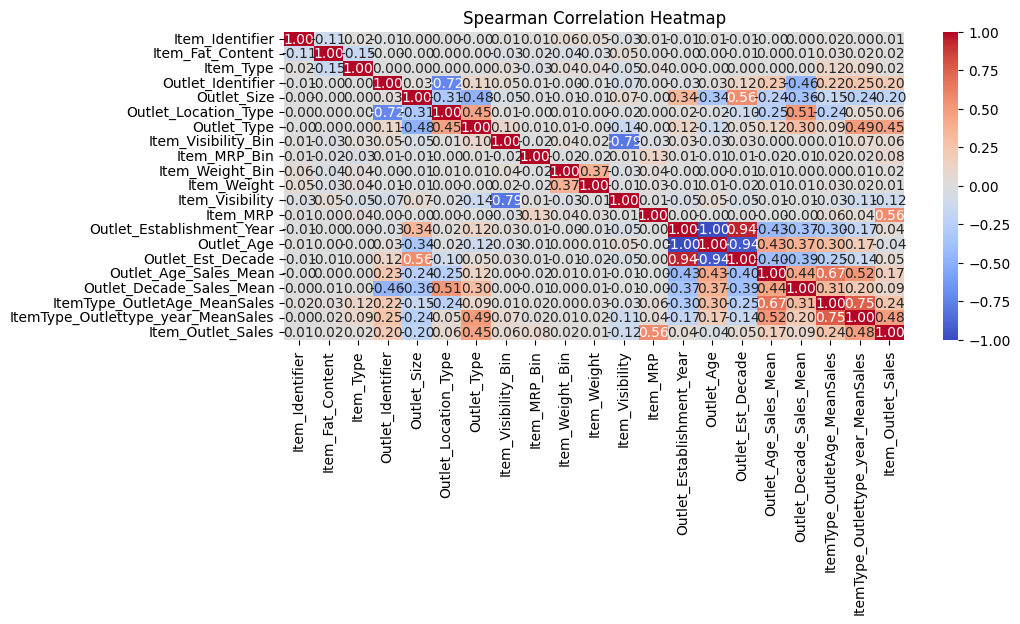

In [7]:
# import sweetviz as sv
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# SPLIT BACK to train/test
df_train_prep = df_all[df_all['is_train']].copy().reset_index(drop=True)
df_test_prep = df_all[~df_all['is_train']].copy().reset_index(drop=True)


df_train_prep = df_train_prep.drop(columns=['is_train'])
df_test_prep = df_test_prep.drop(columns=['is_train', 'Item_Outlet_Sales'])  # Test target is unknown

# report = sv.analyze(df_train_prep)
# report.show_html()

#Correlation again - Will Help us when picking features if Multicollinearity exists
df = df_train_prep.copy()
# Identify categorical and numeric columns
categorical = df.select_dtypes(include=['object', 'category']).columns.tolist()
numeric = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric = [col for col in numeric if col != 'Item_Outlet_Sales']

df_encoded = df.copy()
for col in categorical:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

all_features = categorical + numeric

# Spearman correlation matrix
spearman_corr = df_encoded[all_features + ['Item_Outlet_Sales']].corr(method='spearman')

plt.figure(figsize=(10,4))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Spearman Correlation Heatmap")
plt.show()


We can again check for new features importance like before. Extratrees reduces bias by randomly splitting at each node so we shall use this with Random forest regressor output and select top features

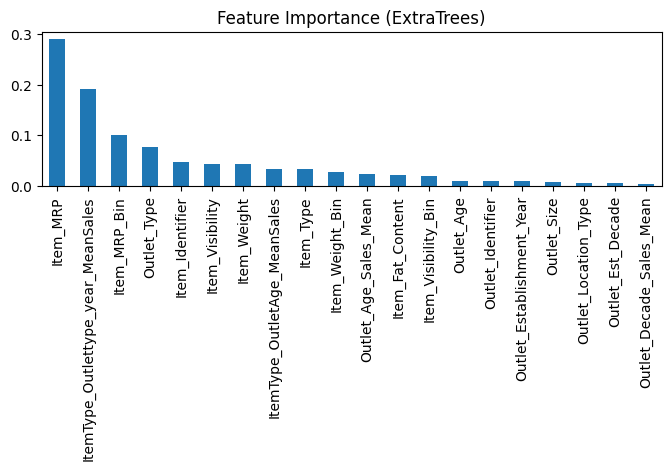

Item_MRP                              0.290544
ItemType_Outlettype_year_MeanSales    0.191863
Item_MRP_Bin                          0.100671
Outlet_Type                           0.076336
Item_Identifier                       0.047283
Item_Visibility                       0.043495
Item_Weight                           0.042540
ItemType_OutletAge_MeanSales          0.032579
Item_Type                             0.032561
Item_Weight_Bin                       0.026916
Outlet_Age_Sales_Mean                 0.023551
Item_Fat_Content                      0.020935
Item_Visibility_Bin                   0.019139
Outlet_Age                            0.010180
Outlet_Identifier                     0.009980
Outlet_Establishment_Year             0.009752
Outlet_Size                           0.007861
Outlet_Location_Type                  0.004786
Outlet_Est_Decade                     0.004592
Outlet_Decade_Sales_Mean              0.004436
dtype: float64


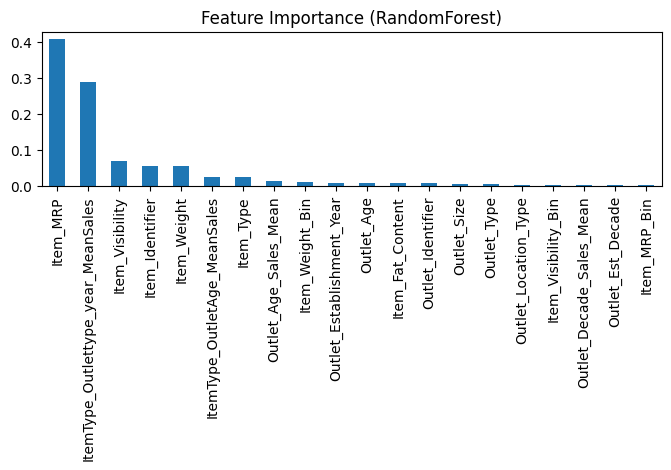

Item_MRP                              0.408228
ItemType_Outlettype_year_MeanSales    0.289027
Item_Visibility                       0.068059
Item_Identifier                       0.055555
Item_Weight                           0.054431
ItemType_OutletAge_MeanSales          0.025385
Item_Type                             0.024553
Outlet_Age_Sales_Mean                 0.013148
Item_Weight_Bin                       0.009634
Outlet_Establishment_Year             0.008828
Outlet_Age                            0.008600
Item_Fat_Content                      0.007382
Outlet_Identifier                     0.007191
Outlet_Size                           0.004589
Outlet_Type                           0.003844
Outlet_Location_Type                  0.003538
Item_Visibility_Bin                   0.002883
Outlet_Decade_Sales_Mean              0.002440
Outlet_Est_Decade                     0.001882
Item_MRP_Bin                          0.000802
dtype: float64


In [8]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

df_for_model = df_train_prep.copy()
categorical_cols = df_for_model.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols = [col for col in categorical_cols]

## ExtraTreesRegressor
for col in cat_cols:
    df_for_model[col] = pd.factorize(df_for_model[col])[0]

X = df_for_model.drop(['Item_Outlet_Sales'], axis=1)
y = df_for_model['Item_Outlet_Sales']

model = ExtraTreesRegressor(n_estimators=500, random_state=42)
model.fit(X, y)
importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(8, 2))
importances.sort_values(ascending=False).plot.bar()
plt.title("Feature Importance (ExtraTrees)")
plt.show()
print(importances.sort_values(ascending=False))

## RF Regressor
for col in cat_cols:
    df_for_model[col] = pd.factorize(df_for_model[col])[0]

X = df_for_model.drop(['Item_Outlet_Sales'], axis=1)
y = df_for_model['Item_Outlet_Sales']

model = RandomForestRegressor(n_estimators=500, random_state=42)
model.fit(X, y)
importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(8, 2))
importances.sort_values(ascending=False).plot.bar()
plt.title("Feature Importance (RandomForest)")
plt.show()
print(importances.sort_values(ascending=False))

Now knowing all feature importance and their correlation with Item Sales and with each other we can skip and use one of the above. In the above after analysis either due to high/mid correlation with item sales or importance of features we shortlist the below features, which we i**teratively reduce by checking performance on test set and the  TEST RANKING.**

'Item_Identifier',

'Item_MRP',

'Outlet_Type',

'Item_Visibility',

'Outlet_Identifier',

'ItemType_Outlettype_year_MeanSales',

'Item Weight'

After multiple trials of predicting and checking test and validation RMSE and recursively removing features we end up with ***'Item_Identifier','Item_MRP','Outlet_Type', 'Item_Visibility','Outlet_Identifier'*** as the final features. We notice Item weight and Item Identifier does not change the result much. Item Identifier is need for getting Rank of the hackathon so this will also ease data wrangling later. The modelling will continue in FINAL MODELLING AND EVALUATION part below.

**We can check for Outliers but we will not remove them as later we see it drastically reduces performance on the TEST Dataset. While in training it may reduce the RMSE but on TEST data it increases the RMSE. And in Retail outliers should be considered. None the less we will show this below with boxplot**

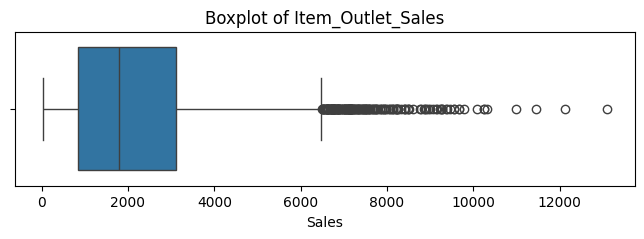

Number of outliers: 186


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

df = df_train_prep.copy()
plt.figure(figsize=(8, 2))
sns.boxplot(x=df['Item_Outlet_Sales'])
plt.title('Boxplot of Item_Outlet_Sales')
plt.xlabel('Sales')
plt.show()

Q1 = df['Item_Outlet_Sales'].quantile(0.25)
Q3 = df['Item_Outlet_Sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


outliers = (df['Item_Outlet_Sales'] < lower_bound) | (df['Item_Outlet_Sales'] > upper_bound)
print(f"Number of outliers: {outliers.sum()}")


## MODEL TRIALS, MODEL SELECTION, and HYPERPARAMETER TUNING

We shall try some models without much processing to see which one consistently gives better results over some test train splits. Tree based models will be better as they handle non linear data well. Linear model will not perform well as data is not linear.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

df_trials = pd.read_csv('./train_v9rqX0R.csv')

X = df_trials.drop(columns=['Item_Outlet_Sales'])
y = df_trials['Item_Outlet_Sales']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=7
)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()


numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])



In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor, Lars, SGDRegressor, BayesianRidge, OrthogonalMatchingPursuit, PassiveAggressiveRegressor, RANSACRegressor, TheilSenRegressor
)
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor, AdaBoostRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "Huber": HuberRegressor(),
    "SGD": SGDRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=7),
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=7),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=7),
    "AdaBoost": AdaBoostRegressor(random_state=7),
    "Bagging": BaggingRegressor(random_state=7),
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=7),
    "SVR": SVR(),
    "CatBoostRegressor" : CatBoostRegressor(iterations=1200,random_state=7,verbose=0),
    "Linear SVR": LinearSVR(),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=7, verbosity=0),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, random_state=7)
}

results = {}

for name, model in models.items():
    try:
        pipe = Pipeline([
            ('preprocess', preprocessor),
            ('model', model)
        ])
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)
        results[name] = {"MSE": mse, "RMSE": rmse}
        print(f"{name} - MSE: {mse:.2f} - RMSE: {rmse:.2f}")
    except Exception as e:
        print(f"{name} failed: {e}")
        continue

results_df = pd.DataFrame(results).T.sort_values("RMSE")


In [ ]:
import pandas as pd
results_df = pd.DataFrame(results).T.sort_values("RMSE")
results_df['RMSE'] = results_df['RMSE'].map('{:.2f}'.format)
print(results_df)


                            MSE               RMSE
Gradient Boosting  1.323172e+06            1150.29
LightGBM           1.331025e+06            1153.70
CatBoostRegressor  1.336100e+06            1155.90
XGBoost            1.365492e+06            1168.54
Lasso              1.408694e+06            1186.88
Huber              1.417491e+06            1190.58
Random Forest      1.433563e+06            1197.31
AdaBoost           1.452267e+06            1205.10
Bagging            1.498314e+06            1224.06
Extra Trees        1.534313e+06            1238.67
Ridge              1.614463e+06            1270.62
KNN                1.628113e+06            1275.98
ElasticNet         1.713534e+06            1309.02
Linear SVR         1.751298e+06            1323.37
Linear Regression  1.793780e+06            1339.32
Decision Tree      2.380798e+06            1542.98
SVR                3.202036e+06            1789.42
SGD                5.119477e+27  71550519223874.05


We see linear models perform very badly for the same seed data split. The top three regressors are **Gradient Boosting, LightGBM and Catboost regressor**. We will use Gradient Boosting and LightGBM post feature engineering and selection.

### Hyper Parameter Tuning and K Fold Cross Validation

We can fine tune Hyperparameters using Optuna or Scikit-Optimise. We pick GBM and LightGBM as the 2 models for hyperparameter tuning and KFold validation

In [ ]:
import optuna
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import numpy as np
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    objective_choice = trial.suggest_categorical(
        "objective", ["tweedie","regression"]
    )
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1800, 2300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.04, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'num_leaves': trial.suggest_int('num_leaves', 30, 128),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-2, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 1, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 0, 0.3),
        'max_bin': trial.suggest_int('max_bin', 63, 255),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt','rf']),
        'random_state': 7,
        'verbosity': -1,
        'objective': objective_choice,
        'feature_fraction': trial.suggest_float('feature_fraction', 0, 1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 30),
    }
    # Only for tweedie
    if objective_choice == "tweedie":
        params['tweedie_variance_power'] = trial.suggest_float('tweedie_variance_power', 1.3, 1.65)

    kf = KFold(n_splits=5, shuffle=True, random_state=7)
    rmses = []
    for train_idx, val_idx in kf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        pipe = Pipeline([
            ('preprocess', preprocessor),
            ('model', lgb.LGBMRegressor(**params))
        ])
        fit_params = {
            'model__eval_set': [(preprocessor.fit_transform(X_val), y_val)],
            'model__eval_metric': 'rmse',
            'model__callbacks': [lgb.early_stopping(550, verbose=False)],
        }
        pipe.fit(X_tr, y_tr, **fit_params)
        preds = pipe.predict(X_val)
        preds = np.clip(preds, 0, None)  # no negative sales
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmses.append(rmse)
    return np.mean(rmses)


study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=7))
study.optimize(objective, n_trials=800, show_progress_bar=True)

print("Best trial:")
print("  Value (RMSE):", study.best_value)
print("  Params:", study.best_trial.params)
print("  Best objective:", study.best_trial.params["objective"])


Using Scikit-Optimise

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from skopt import BayesSearchCV
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

cv = KFold(n_splits=5, shuffle=True, random_state=7)

lgb_params = {
    'model__n_estimators': (100, 1100),
    'model__learning_rate': (0.01, 0.15, 'log-uniform'),
    'model__max_depth': (2, 10),
    'model__num_leaves': (10, 100),
    'model__subsample': (0.5, 1.0, 'uniform'),
    'model__colsample_bytree': (0.5, 1.0, 'uniform')
}

lgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', lgb.LGBMRegressor(random_state=7))
])

lgb_search = BayesSearchCV(
    lgb_pipeline, lgb_params, n_iter=10, cv=cv, scoring='neg_root_mean_squared_error',
    random_state=7, n_jobs=-1, verbose=2
)

lgb_search.fit(X_train, y_train)

print('Best LightGBM params:', lgb_search.best_params_)
print('Best LightGBM CV RMSE:', -lgb_search.best_score_)

lgb_rand_params = {
    'model__n_estimators': np.arange(100, 1200, 100),
    'model__learning_rate': np.logspace(-2, -0.5, 10),
    'model__max_depth': np.arange(2, 11),
    'model__num_leaves': np.arange(10, 101, 10),
    'model__subsample': np.linspace(0.5, 1.0, 6),
    'model__colsample_bytree': np.linspace(0.5, 1.0, 6)
}

lgb_rand_search = RandomizedSearchCV(
    lgb_pipeline, lgb_rand_params, n_iter=10, cv=cv,
    scoring='neg_root_mean_squared_error', random_state=7, n_jobs=-1, verbose=2
)

lgb_rand_search.fit(X_train, y_train)

print('RandomizedSearchCV best params:', lgb_rand_search.best_params_)
print('RandomizedSearchCV best CV RMSE:', -lgb_rand_search.best_score_)


We get results for this like below:

Best trial:
   Value (RMSE): 1072.113754893237
   Params: {'objective': 'tweedie', 'n_estimators': 2173, 'learning_rate': 0.03419883695488359, 'max_depth': 2, 'num_leaves': 128, 'min_child_samples': 10, 'subsample': 0.8046557236892438, 'colsample_bytree': 0.7376586630774093, 'reg_alpha': 0.02846306958662256, 'reg_lambda': 0.002916596371144482, 'min_split_gain': 0.23100334028784064, 'max_bin': 68, 'boosting_type': 'gbdt', 'min_data_in_leaf': 29, 'tweedie_variance_power': 1.4508369853798866}
   Best objective: tweedie

## FINAL MODELLING, EVALUATION, and INTERPRETATION

We continue from where we left off before Model Trials and Hyper Parameter Tuning.

In [10]:
# Feature/target split for model

features = ['Item_Identifier','Item_MRP','Outlet_Type',
            'Item_Visibility', 'Outlet_Identifier'] #,'Item_Weight_Bin',
            #,'ItemType_Outlettype_year_MeanSales',
            #,'Outlet_Age_Sales_Mean','Outlet_Decade_Sales_Mean','ItemType_OutletAge_MeanSales']
target = 'Item_Outlet_Sales'

X = df_train_prep[features]
y = df_train_prep[target]
X_test_final = df_test_prep[features]  # Hold out for final prediction

numeric_features = ['Item_MRP', 'Item_Visibility']
categorical_features = ['Outlet_Type', 'Outlet_Identifier','Item_Identifier']

## Imputations added in case anything is missed out it will add the below imputations

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()) #Standard Scaling improves performance and reducesthe RMSE!
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2 ,shuffle=True, random_state=7
)

In [11]:
from sklearn.metrics import r2_score

def adjusted_r2_score(y_true, y_pred, n_features):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    return adj_r2

In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

model = lgb.LGBMRegressor(
    objective = 'tweedie',
    tweedie_variance_power = 1.53,
    colsample_bytree=1.0,
    learning_rate=0.0314,
    max_depth=2,
    n_estimators=2100,
    num_leaves=100,
    subsample=0.8,
    verbose=-1,
    reg_alpha=0.0285,
    reg_lambda= 0.00292,
    feature_fraction = 0.9,
    min_data_in_leaf = 19,
    min_split_gain = 0.289
    )

results = {}
pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', model)
])
pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)
preds = np.clip(preds, 0, None)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
results['LightGBM'] = {"MSE": mse, "RMSE": rmse}
print(f" - MSE: {mse:.2f} - RMSE: {rmse:.2f}")

results_df = pd.DataFrame(results).T.sort_values("RMSE")
print(results_df)

r2 = r2_score(y_test, preds)
adj_r2 = adjusted_r2_score(y_test, preds, n_features=X_test.shape[1])
print("R2 score:", r2)
print("Adjusted R2:", adj_r2)

 - MSE: 1297776.60 - RMSE: 1139.20
                   MSE         RMSE
LightGBM  1.297777e+06  1139.199982
R2 score: 0.5804486281274488
Adjusted R2: 0.5792139272096367


In [15]:
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(
    learning_rate=0.01,
    max_depth=9,
    min_samples_leaf=20,
    min_samples_split=14,
    n_estimators=353,
    subsample=0.5,
    random_state=7
)

results = {}
pipe2 = Pipeline([
    ('preprocess', preprocessor),
    ('model', model)
])
pipe2.fit(X_train, y_train)
preds = pipe2.predict(X_test)
preds = np.clip(preds, 0, None)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
results['Gradient Boosting'] = {"MSE": mse, "RMSE": rmse}
print(f"Gradient Boosting - MSE: {mse:.2f} - RMSE: {rmse:.2f}")

results_df2 = pd.DataFrame(results).T.sort_values("RMSE")
print(results_df2)

r2 = r2_score(y_test, preds)
adj_r2 = adjusted_r2_score(y_test, preds, n_features=X_test.shape[1])
print("R2 score:", r2)
print("Adjusted R2:", adj_r2)

Gradient Boosting - MSE: 1291081.24 - RMSE: 1136.26
                            MSE         RMSE
Gradient Boosting  1.291081e+06  1136.257558
R2 score: 0.5826131363003924
Adjusted R2: 0.5813848053301169


In [16]:
print(results_df,'\n\n',results_df2)

                   MSE         RMSE
LightGBM  1.297777e+06  1139.199982 

                             MSE         RMSE
Gradient Boosting  1.291081e+06  1136.257558


In [54]:
y_pred2 = pipe.predict(X_test_final)
output = pd.DataFrame({'Item_Identifier': X_test_final['Item_Identifier'], 'Outlet_Identifier': X_test_final['Outlet_Identifier'], 'Item_Outlet_Sales': y_pred2})
print('TEST SAMPLE \n' ,output.head(5))

output.to_csv('submission_aks803_LightGBM_0.2t_rmse1133.csv', index=False)

TEST SAMPLE 
   Item_Identifier Outlet_Identifier  Item_Outlet_Sales
0           FDW58            OUT049        1577.300593
1           FDW14            OUT017        1346.980668
2           NCN55            OUT010         564.706203
3           FDQ58            OUT017        2662.099900
4           FDY38            OUT027        5702.114612


Though GBM shows lesser RMSE when we predict and predict on the TEST dataset we see LightGBM is better and has lower RMSE.

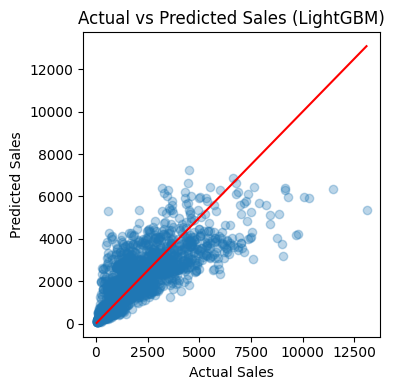

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.scatter(y_test, preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales (LightGBM)")
plt.tight_layout()
plt.show()

### We can use SHAP to do some model interpretation if needed at each record level

 99%|===================| 1694/1705 [00:28<00:00]       

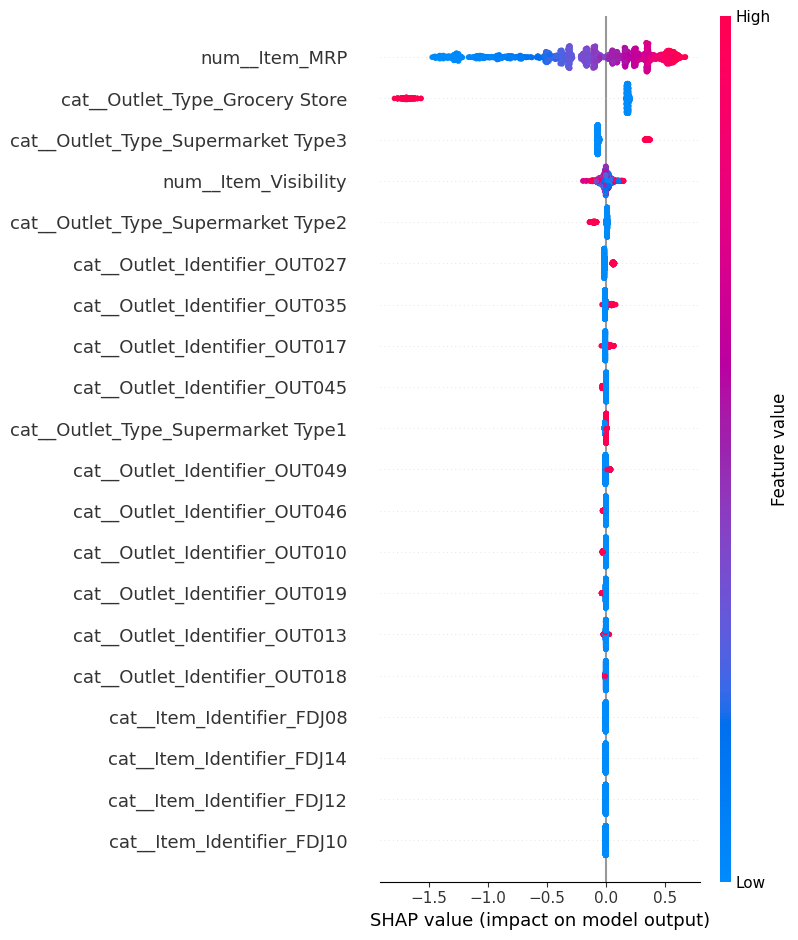

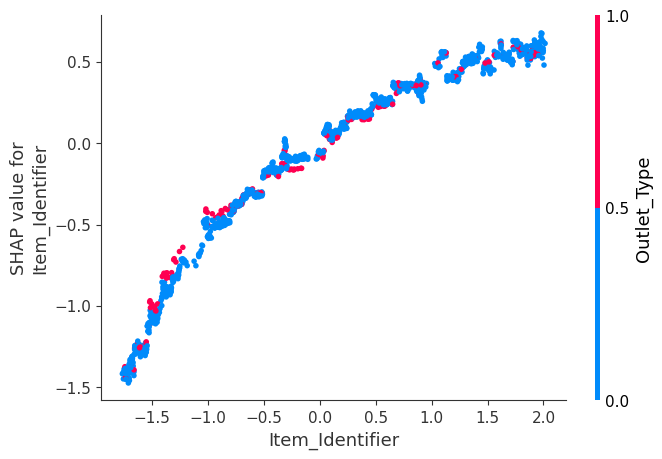

In [44]:
import shap
model_shap = pipe.named_steps['model']
X_test_preprocessed = pipe.named_steps['preprocess'].transform(X_test)

explainer = shap.Explainer(model_shap, X_test_preprocessed,feature_names=pipe.named_steps['preprocess'].get_feature_names_out())
shap_values = explainer(X_test_preprocessed)

feature_names = pipe.named_steps['preprocess'].get_feature_names_out()
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names)

shap.dependence_plot(0, shap_values.values, X_test_preprocessed, feature_names=X_test.columns)

In [47]:
import shap
import pandas as pd

model_shap = pipe.named_steps['model']
X_test_preprocessed = pipe.named_steps['preprocess'].transform(X_test)
feature_names = pipe.named_steps['preprocess'].get_feature_names_out()


explainer = shap.Explainer(model_shap, X_test_preprocessed)
shap_values = explainer(X_test_preprocessed)

 97%|=================== | 1656/1705 [00:28<00:00]       

In [53]:
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Pick row to explain
i = 0
row_shap = shap_values[i]
row_features = X_test_preprocessed[i]
row_feature_names = feature_names

actual_sale_log = y_test.iloc[i]
predicted_sale_log = pipe.predict(X_test.iloc[[i]])[0]
expected_value_log = explainer.expected_value
sum_shap_log = row_shap.values.sum()

# Inverse transform as shap values are in log
actual_sale = np.expm1(actual_sale_log)
predicted_sale = np.expm1(predicted_sale_log)
expected_value = np.expm1(expected_value_log)
sum_shap = np.expm1(sum_shap_log)
sum_shap_plus_expected = np.expm1(sum_shap_log + expected_value_log)

print(f"Predicted Sales (Actual): {predicted_sale_log:.2f}")
print(f"Actual Sales (Actual):    {actual_sale_log:.2f}")
print(f"Model's average prediction (log): {expected_value_log:.2f}")
print(f"Model's average prediction (actual): {expected_value:.2f}")
print(f"Sum of SHAP contributions (log): {sum_shap_log:.2f}")
print(f"Sum of SHAP contributions + expected value (log): {sum_shap_log + expected_value_log:.2f}")
print(f"Sum of SHAP contributions (actual): {sum_shap:.2f}")
print(f"Sum of SHAP contributions + expected value (actual): {sum_shap_plus_expected:.2f}")


shap_contributions = pd.DataFrame({
    'Feature': row_feature_names,
    'Feature Value': row_features,
    'SHAP Value (log)': row_shap.values,
    'SHAP Value (actual)': np.expm1(row_shap.values)
}).sort_values('SHAP Value (log)', key=abs, ascending=False)

print("\nBreakdown for this prediction (largest contributors first):")
print(shap_contributions.head(10))

Predicted Sales (Actual): 2532.13
Actual Sales (Actual):    2535.37
Model's average prediction (log): 7.59
Model's average prediction (actual): 1975.17
Sum of SHAP contributions (log): 0.25
Sum of SHAP contributions + expected value (log): 7.84
Sum of SHAP contributions (actual): 0.28
Sum of SHAP contributions + expected value (actual): 2531.13

Breakdown for this prediction (largest contributors first):
                               Feature  Feature Value  SHAP Value (log)  \
2       cat__Outlet_Type_Grocery Store       0.000000          0.189090   
0                        num__Item_MRP       0.282529          0.158949   
5   cat__Outlet_Type_Supermarket Type3       0.000000         -0.068834   
13       cat__Outlet_Identifier_OUT045       1.000000         -0.028442   
11       cat__Outlet_Identifier_OUT027       0.000000         -0.011972   
4   cat__Outlet_Type_Supermarket Type2       0.000000          0.009950   
12       cat__Outlet_Identifier_OUT035       0.000000         -0.00

#### **How the features affected this prediction**:

Outlet is not a Grocery Store: This pushes sales up by about +208 units.

Item has a high price (Item_MRP): Adds +172 units to the predicted sales (expensive item = higher sales expected).

Outlet is not Supermarket Type 3: Subtracts about -67 units.

Outlet_Identifier_OUT045 is present: Slightly decreases the prediction by about -28 units (this outlet may have lower sales on average).

Outlet_Identifier_OUT027 is absent: Tiny effect, but removes about -12 units.

Outlet is not Supermarket Type 2: Adds a very small +10 units.

Outlet_Identifier_OUT035 is absent: Very small decrease (-5 units).

Outlet is Supermarket Type 1: Slight increase (+4 units).

Outlet_Identifier_OUT017 is absent: Slight decrease (-3 units).

Item_Visibility is moderately high: Almost no effect (+2 units).



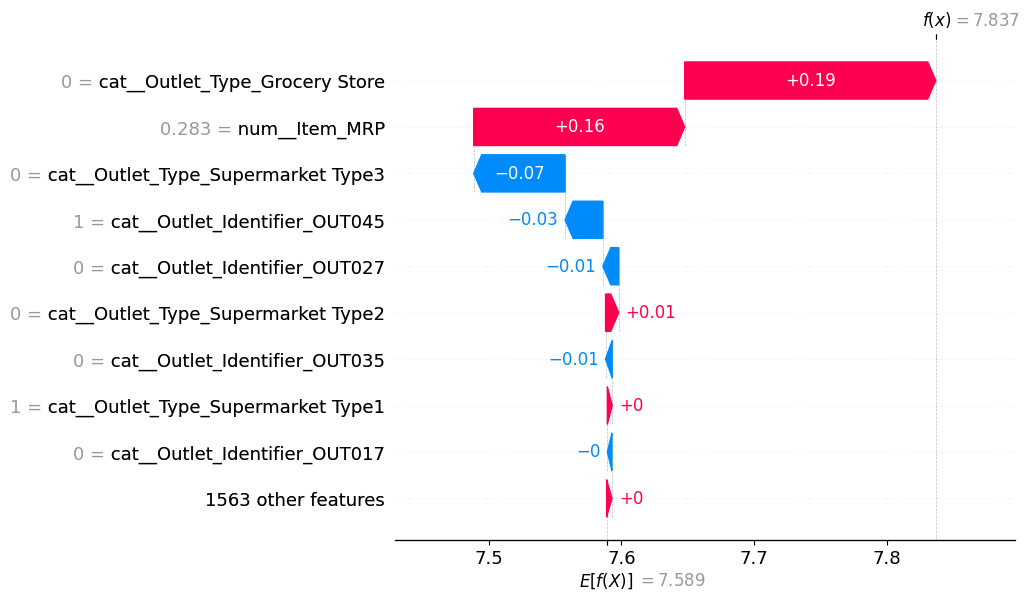

In [46]:
shap.plots.waterfall(shap_values[0], max_display=10)

#### MODEL INTERPRETATION

Price is the primary component the model considers, and expensive things are anticipated to have larger sales.

Types of supermarkets are important: Grocery stores often have lower predicted sales than type 3 stores.

It is anticipated that products with greater shelf visibility may sell fewer units, perhaps as a result of excessive promotion or discounts.

Based on store ID, the model learns which individual stores sell better or worse and modifies forecasts accordingly.

Because the model concentrates more on broad trends than on specific locations, store-specific impacts are less pronounced than those of broad patterns like price or outlet type.

Predictions are more enhanced by high prices than by moderately high ones; the model probably detects "premium" pricing and makes the necessary adjustments.

Different outlet types have different effects on predictions; some, like grocery stores, pull down sales, while others, like Type 3, push them up significantly.

Surprisingly, while highly visible items tend to lower predicted sales, low-visibility items raise them slightly.

A few essential features account for the majority of the prediction power; the remaining features are negligible and could be eliminated without degrading performance.

Certain items consistently increase or decrease predicted sales — some products (Item_Identifiers) have a strong built-in effect on the model’s sales forecast.

As the Item_Identifier value rises, so does its positive impact — items toward the right (higher values) tend to push sales predictions up, while those on the left lower them.

Outlet_Type (in color) doesn’t strongly change this pattern — whether it's blue (one type) or red (another), the trend stays similar, so Outlet_Type isn’t strongly interacting with Item_Identifier here.

The relationship is smooth and curved, not random — the model has learned a clear, non-linear connection between item identity and sales behavior.

## **VERDICT**

We observed that Gradient Boosting(GBM) and LightGBM were the best models out there. Other methods like Stacking and Bagging can also be tried where we use Tree based models, along with Lasso and Ridge regression, or other models. Stacking gave a good result in the range of 1136-1142 on the TEST dataset. However LightGBM was better alone versus in combination. Though dataset is small and Deep Learning is not recommended, tabular transformers and neural networks were tried but traditional ML Models beat them. If the dataset was large enough for learning maybe Deep Learning will outperform these ML Models. Another option considered was Log Transformation(Box Cox Transformation) and then try linear models. This was also not giving optimal results.

While we see Gradient Boosting is outperforming LightGBM here on this test dataset , the Validation test data on the Hackathon will give 1146.28 as the RMSE whereas the **LightGBM model gives 1133.28 RMSE**! This clearly shows that while GBM will outperform LightGBM on the training dataset(split into train/test) in almost every fold of cross validation, when put into practice and predicted on the main Test dataset it performs poorly in comparison to LightGBM. By changing and optimising the Hyperparameters of LightGBM one can reduce the RMSE from 1140+ to 1133 and maybe even lesser. Some other observations include the use of Standard Scaler improving the TEST RMSE, removing Outliers increases RMSE, and Capping outliers instead helps improve performance and reduces the RMSE but leaving the outliers as it is works the best. After modelling and evaluation we can use SHAP to interpret the model on different sales values and see which features contribute more or less. We can even drop the ones which fail to contribute towards the model prediction e.g. a particular Outlet type or Outlet Identifier etc. This could also enhance the model.

This along with the fact that LightGBM is faster, uses lesser memory, works great on larger datasets, handles missing values, the **Tweedie Objective** in LightGBM **helps take care of outliers and extreme skewness(gamma distribution), Poisson distributions etc**. which is very ideal for Retail Sales where we need Outliers as these sales are not random and can have seasonality and temporal influence. Removing outliers might show reduced RMSE while training the model but in practice and here it increases the RMSE on the given TEST dataset.

#### **LightGBM is the winner with the lowest Test RMSE.**